##Deep Learning Team Project - RNN model for USDCAD FX prediction
###Group Member:
###Andrew Liu
###Obim Okongwu
###Houssain Bakhtar
###Deqiang Wang
###Kewei Chen


###Import necessary functions
###The main models we are trying to explore here are SimpleRNN, GRU, and LSTM

In [0]:
import os
import pandas as pd
import zipfile
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, SimpleRNN, GRU, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
best.weights  drive  sample_data  weights.best	weights.best.hdf5


# Prepare Clean Data
## USDCAD Bid & Ask price since 2012
### There are two sets of files downloaded from https://www.histdata.com/download-free-forex-data/
### 1) Bid price, Open, High, Low, Close and Volume. The volume column has zeros which is not useful. This data set is 1 min interval
### 2) Ask price with 1 second interval. However, the data is not clean that it's not consistently 1 second interval

### These two sets of data need to be merged with 1 min interval and also cleaning up all the potentail gaps/issues in the data

In [0]:
# Load the raw files with bid USDCAD prices

bid_path = 'drive/My Drive/BidRawData/'

bid_dfs = []

for subdir, dirs, files in os.walk(bid_path): # go through the files and subfolders in a parent folder
    for zipp in files:
        filepath= os.path.join(subdir, zipp) # obtain the file full path
        zf = zipfile.ZipFile(filepath) 
        text_files = zf.infolist() # obtain info of the list of files in the zip file
        for text_file in text_files:
          csv_file = text_file.filename # obtain file names of the list of files in the zip file
          if csv_file.endswith('csv'): # only work with the csv file within the zip file
            # read in the csv file and deliminate it with ';'. Aslo, adding the header names for the fields
            bid_df = pd.read_csv(zf.open(csv_file), sep=";", names=["timestamp", "openbid", "highbid", "lowbid", "closebid", "volume"])
            bid_df = bid_df.drop('volume', axis=1) # drop off the volume data because they are all zeros which is not useful
            bid_df['timestamp'] = pd.to_datetime(bid_df['timestamp']) # convert the strings in time column to actual datatime format
            bid_dfs.append(bid_df) # append each individual dataset to the overall dataset

bid_df = pd.concat(bid_dfs) # concatenate all of the individual datasets into one
bid_df.index = bid_df['timestamp'] # set the time column as the index of the dataset
bid_df = bid_df.resample('T').mean() # pre-sample the data as 1 min interval. This can be used to resample into another dataset with any lower frequency. 10mins, 1hour or 1 day, etc

In [0]:
print(bid_df.info())
print(bid_df.head(20)) # precheck the data. It was noticed there are some 1 min marks missing data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3937858 entries, 2012-01-02 02:00:00 to 2019-06-28 16:57:00
Freq: T
Data columns (total 4 columns):
openbid     float64
highbid     float64
lowbid      float64
closebid    float64
dtypes: float64(4)
memory usage: 150.2 MB
None
                     openbid  highbid   lowbid  closebid
timestamp                                               
2012-01-02 02:00:00  1.01926  1.01926  1.01925   1.01926
2012-01-02 02:01:00      NaN      NaN      NaN       NaN
2012-01-02 02:02:00      NaN      NaN      NaN       NaN
2012-01-02 02:03:00      NaN      NaN      NaN       NaN
2012-01-02 02:04:00  1.01925  1.01925  1.01925   1.01925
2012-01-02 02:05:00  1.01918  1.01918  1.01917   1.01917
2012-01-02 02:06:00  1.01918  1.01918  1.01918   1.01918
2012-01-02 02:07:00      NaN      NaN      NaN       NaN
2012-01-02 02:08:00  1.01925  1.01925  1.01925   1.01925
2012-01-02 02:09:00      NaN      NaN      NaN       NaN
2012-01-02 02:10:00      NaN      Na

In [0]:
# resample the data with 10 min interval
# each price needs to be treated differently for the resampling which is listed below:
# 1. the openbid price needs to be the first price during the time interval
# 2. the closebid price needs to be the last price during the time interval
# 3. the highbid needs to be the highest price during the time interval
# 4. the lowbid needs to be the lowest price during the time interval

# create seperate dataframes to archive the above functionalities

openbid_df=bid_df.drop(['highbid','lowbid','closebid'], axis=1)
closebid_df=bid_df.drop(['highbid','lowbid','openbid'], axis=1)
highlowbid_df=bid_df.drop(['openbid','closebid'], axis=1)

# resample the data as needed
openbid_df = openbid_df.resample('10T').first()
closebid_df = closebid_df.resample('10T').last()
highlowbid_df = highlowbid_df.resample('10T').agg({'highbid': np.max, 'lowbid': np.min})

# re-combine the dataframes
finalbid_df = openbid_df.join(highlowbid_df, how='left').join(closebid_df, how='left')
finalbid_df.head(20)

,openbid,highbid,lowbid,closebid
timestamp,,,,
2012-01-02 02:00:00,1.01926,1.01926,1.01917,1.01925
2012-01-02 02:10:00,1.01924,1.01927,1.01917,1.01927
2012-01-02 02:20:00,1.01921,1.01995,1.01900,1.01944
2012-01-02 02:30:00,1.01946,1.01947,1.01883,1.01898
2012-01-02 02:40:00,1.01900,1.01918,1.01882,1.01914
2012-01-02 02:50:00,1.01917,1.01917,1.01906,1.01913
2012-01-02 03:00:00,1.01906,1.01913,1.01886,1.01887
2012-01-02 03:10:00,1.01880,1.01880,1.01833,1.01873
2012-01-02 03:20:00,1.01868,1.01875,1.01859,1.01874


In [0]:
# check the final bid price data after the resampling. It was noticed there are still some null values
# The null values is largely because of the trading convention of USDCAD market
# USDCAD market closes at 5pm Friday and re-opens at 5pm Sunday (EST), which is the Monday morning of Australia.
# As a result, you will notice roughly 1 / 3 of the data is null. (2 out of 7 days)

print(finalbid_df.info())
print(finalbid_df.isnull().sum())

bad_df = finalbid_df[finalbid_df.isna().any(axis=1)]
print(bad_df[-50:])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 393786 entries, 2012-01-02 02:00:00 to 2019-06-28 16:50:00
Freq: 10T
Data columns (total 4 columns):
openbid     279191 non-null float64
highbid     279191 non-null float64
lowbid      279191 non-null float64
closebid    279191 non-null float64
dtypes: float64(4)
memory usage: 25.0 MB
None
openbid     114595
highbid     114595
lowbid      114595
closebid    114595
dtype: int64
                     openbid  highbid  lowbid  closebid
timestamp                                              
2019-06-23 08:40:00      NaN      NaN     NaN       NaN
2019-06-23 08:50:00      NaN      NaN     NaN       NaN
2019-06-23 09:00:00      NaN      NaN     NaN       NaN
2019-06-23 09:10:00      NaN      NaN     NaN       NaN
2019-06-23 09:20:00      NaN      NaN     NaN       NaN
2019-06-23 09:30:00      NaN      NaN     NaN       NaN
2019-06-23 09:40:00      NaN      NaN     NaN       NaN
2019-06-23 09:50:00      NaN      NaN     NaN       NaN
2019-06

In [0]:
# use forward fill to full up the missing data in weekends
finalbid_df = finalbid_df.fillna(method='ffill')
print(finalbid_df.isnull().sum())

openbid     0
highbid     0
lowbid      0
closebid    0
dtype: int64


In [0]:
ask_path = 'drive/My Drive/AskRawData/'

ask_dfs = []

for subdir, dirs, files in os.walk(ask_path):
    for zipp in files:
        filepath= os.path.join(subdir, zipp)
        zf = zipfile.ZipFile(filepath)
        text_files = zf.infolist()
        for text_file in text_files:
          csv_file = text_file.filename
          if csv_file.endswith('csv'):
            ask_df = pd.read_csv(zf.open(csv_file), sep=";", names=["timestamp", "ask", "volume"])
            ask_df = ask_df.drop('volume', axis=1)
            ask_df['timestamp'] = pd.to_datetime(ask_df['timestamp'])
            ask_dfs.append(ask_df)

ask_df = pd.concat(ask_dfs)
ask_df.index = ask_df['timestamp']
ask_df = ask_df.resample('T').mean()

In [0]:
finalask_df = ask_df.resample('10T').mean()
print(finalask_df.info())
print(finalask_df.isnull().sum())

badask_df = finalask_df[finalask_df.isna().any(axis=1)]
print(badask_df[-50:])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 393786 entries, 2012-01-02 02:00:00 to 2019-06-28 16:50:00
Freq: 10T
Data columns (total 1 columns):
ask    279191 non-null float64
dtypes: float64(1)
memory usage: 6.0 MB
None
ask    114595
dtype: int64
                     ask
timestamp               
2019-06-23 08:40:00  NaN
2019-06-23 08:50:00  NaN
2019-06-23 09:00:00  NaN
2019-06-23 09:10:00  NaN
2019-06-23 09:20:00  NaN
2019-06-23 09:30:00  NaN
2019-06-23 09:40:00  NaN
2019-06-23 09:50:00  NaN
2019-06-23 10:00:00  NaN
2019-06-23 10:10:00  NaN
2019-06-23 10:20:00  NaN
2019-06-23 10:30:00  NaN
2019-06-23 10:40:00  NaN
2019-06-23 10:50:00  NaN
2019-06-23 11:00:00  NaN
2019-06-23 11:10:00  NaN
2019-06-23 11:20:00  NaN
2019-06-23 11:30:00  NaN
2019-06-23 11:40:00  NaN
2019-06-23 11:50:00  NaN
2019-06-23 12:00:00  NaN
2019-06-23 12:10:00  NaN
2019-06-23 12:20:00  NaN
2019-06-23 12:30:00  NaN
2019-06-23 12:40:00  NaN
2019-06-23 12:50:00  NaN
2019-06-23 13:00:00  NaN
2019-06-23 13:10:0

In [0]:
finalask_df = finalask_df.fillna(method='ffill')
print(finalask_df.isnull().sum())


ask    0
dtype: int64


In [0]:
final_df = finalask_df.join(finalbid_df, how='left')
# final_df = final_df.fillna(method='ffill')
# final_df = final_df.truncate(before='2015-01-05', after='2015-12-27') # This selects a specific period of time in the dataset
final_df.head()

,ask,openbid,highbid,lowbid,closebid
timestamp,,,,,
2012-01-02 02:00:00,1.019522,1.01926,1.01926,1.01917,1.01925
2012-01-02 02:10:00,1.019500,1.01924,1.01927,1.01917,1.01927
2012-01-02 02:20:00,1.019535,1.01921,1.01995,1.01900,1.01944
2012-01-02 02:30:00,1.019432,1.01946,1.01947,1.01883,1.01898
2012-01-02 02:40:00,1.019354,1.01900,1.01918,1.01882,1.01914


In [0]:
df=final_df

In [0]:
df.count()

ask         393786
openbid     393786
highbid     393786
lowbid      393786
closebid    393786
dtype: int64

In [0]:
df.index.min(), df.index.max()

(Timestamp('2012-01-02 02:00:00'), Timestamp('2019-06-28 16:50:00'))

##Redefine the time column to timestamps to be recognized and used in the model
###Added some addtional features(factors) to the data frame 
###1) High - Low
###2) Open - Close
###3) Average of High and Low
###4) Average of High, Low, Open, and Close
###5) Bid, Ask Spread

##By adding more features to the model, we are trying to help the model to better learn the data and improve accuracy

In [0]:
# Add additional features
df['hour'] = df.index.hour
df['day']  = df.index.weekday
df['week'] = df.index.week

df['avgprx'] = (df['lowbid'] + df['highbid'])/2
df['HML']     = df['highbid'] - df['lowbid']
df['meanprx'] = (df['lowbid'] + df['highbid'] + df['openbid'] + df['closebid'])/4
df['OMC']    = df['openbid'] - df['closebid']
df['spread'] = df['ask'] - df['lowbid']

In [0]:
df.head()

,ask,openbid,highbid,lowbid,closebid,hour,day,week,avgprx,HML,meanprx,OMC,spread
timestamp,,,,,,,,,,,,,
2012-01-02 02:00:00,1.019522,1.01926,1.01926,1.01917,1.01925,2,0,1,1.019215,0.00009,1.019235,0.00001,0.000352
2012-01-02 02:10:00,1.019500,1.01924,1.01927,1.01917,1.01927,2,0,1,1.019220,0.00010,1.019238,-0.00003,0.000330
2012-01-02 02:20:00,1.019535,1.01921,1.01995,1.01900,1.01944,2,0,1,1.019475,0.00095,1.019400,-0.00023,0.000535
2012-01-02 02:30:00,1.019432,1.01946,1.01947,1.01883,1.01898,2,0,1,1.019150,0.00064,1.019185,0.00048,0.000602
2012-01-02 02:40:00,1.019354,1.01900,1.01918,1.01882,1.01914,2,0,1,1.019000,0.00036,1.019035,-0.00014,0.000534


###Create dataset

In [0]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

###Feature Analysis (heatmap correlation matrix)

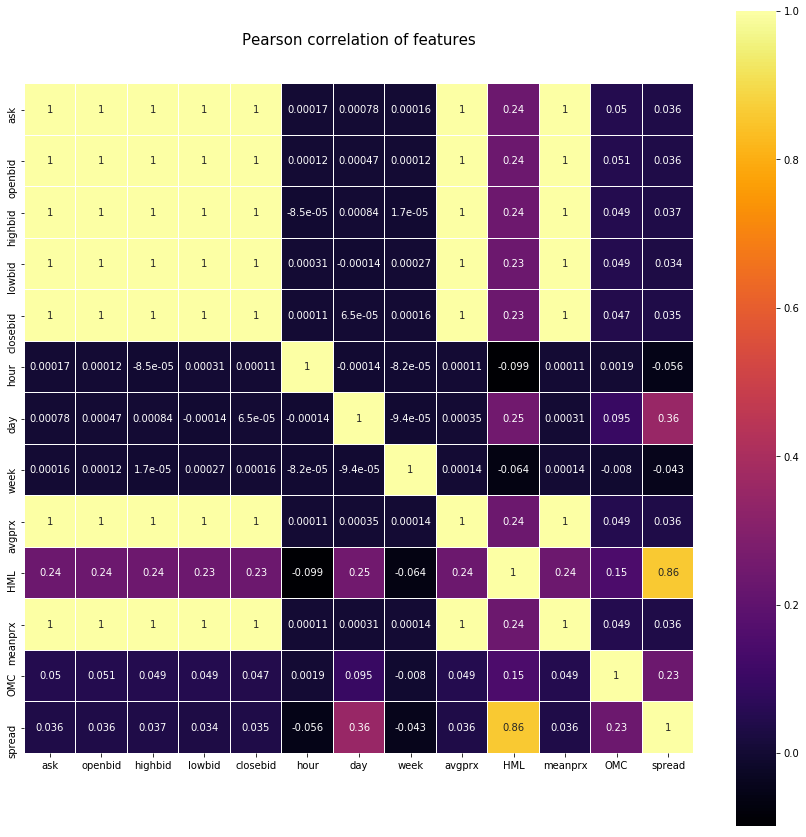

In [0]:
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()


##Prep data for RNN
###Use MinMaxScaler to transform/normolize the data
###Split the data into 90% training and 10% testing

In [0]:
# Scale and create datasets
target_index = df.columns.tolist().index('closebid')
high_index = df.columns.tolist().index('highbid')
low_index = df.columns.tolist().index('lowbid')
dataset = df.values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

    
# Set look_back to 12 which is 2 hrs (10min*12)
X, y = create_dataset(dataset, look_back=12)
y = y[:,target_index]



In [0]:
# Set training data size
train_size = int(len(X) * 0.90)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

#First model - SimpleRNN with SELU activation function

In [0]:
# create a simple RNN network
model_SRNN = Sequential()
model_SRNN.add(SimpleRNN(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_SRNN.add(SimpleRNN(20, return_sequences=True))
model_SRNN.add(SimpleRNN(10, return_sequences=True))
model_SRNN.add(Dropout(0.2))
model_SRNN.add(SimpleRNN(4, return_sequences=False))
model_SRNN.add(Dense(4, kernel_initializer='uniform', activation='selu'))
model_SRNN.add(Dense(1, kernel_initializer='uniform', activation='selu'))

model_SRNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model_SRNN.summary())


W0714 19:17:06.295534 139655915046784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 19:17:06.323848 139655915046784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 19:17:06.330605 139655915046784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 19:17:06.754675 139655915046784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0714 19:17:06.764077 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 12, 20)            680       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 12, 20)            820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 12, 10)            310       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 10)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 4)                 60        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total para

In [0]:
# Save the best weight during training.
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best.weights", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint]
history = model_SRNN.fit(trainX, trainY, epochs=20, batch_size=250, verbose=0, callbacks=callbacks_list, validation_split=0.1)

W0714 19:17:23.291150 139655915046784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.




Epoch 00001: val_mean_squared_error improved from inf to 0.00011, saving model to best.weights

Epoch 00002: val_mean_squared_error improved from 0.00011 to 0.00003, saving model to best.weights

Epoch 00003: val_mean_squared_error improved from 0.00003 to 0.00002, saving model to best.weights

Epoch 00004: val_mean_squared_error improved from 0.00002 to 0.00001, saving model to best.weights

Epoch 00005: val_mean_squared_error did not improve from 0.00001

Epoch 00006: val_mean_squared_error did not improve from 0.00001

Epoch 00007: val_mean_squared_error did not improve from 0.00001

Epoch 00008: val_mean_squared_error did not improve from 0.00001

Epoch 00009: val_mean_squared_error did not improve from 0.00001

Epoch 00010: val_mean_squared_error did not improve from 0.00001

Epoch 00011: val_mean_squared_error did not improve from 0.00001

Epoch 00012: val_mean_squared_error did not improve from 0.00001

Epoch 00013: val_mean_squared_error improved from 0.00001 to 0.00001, savin

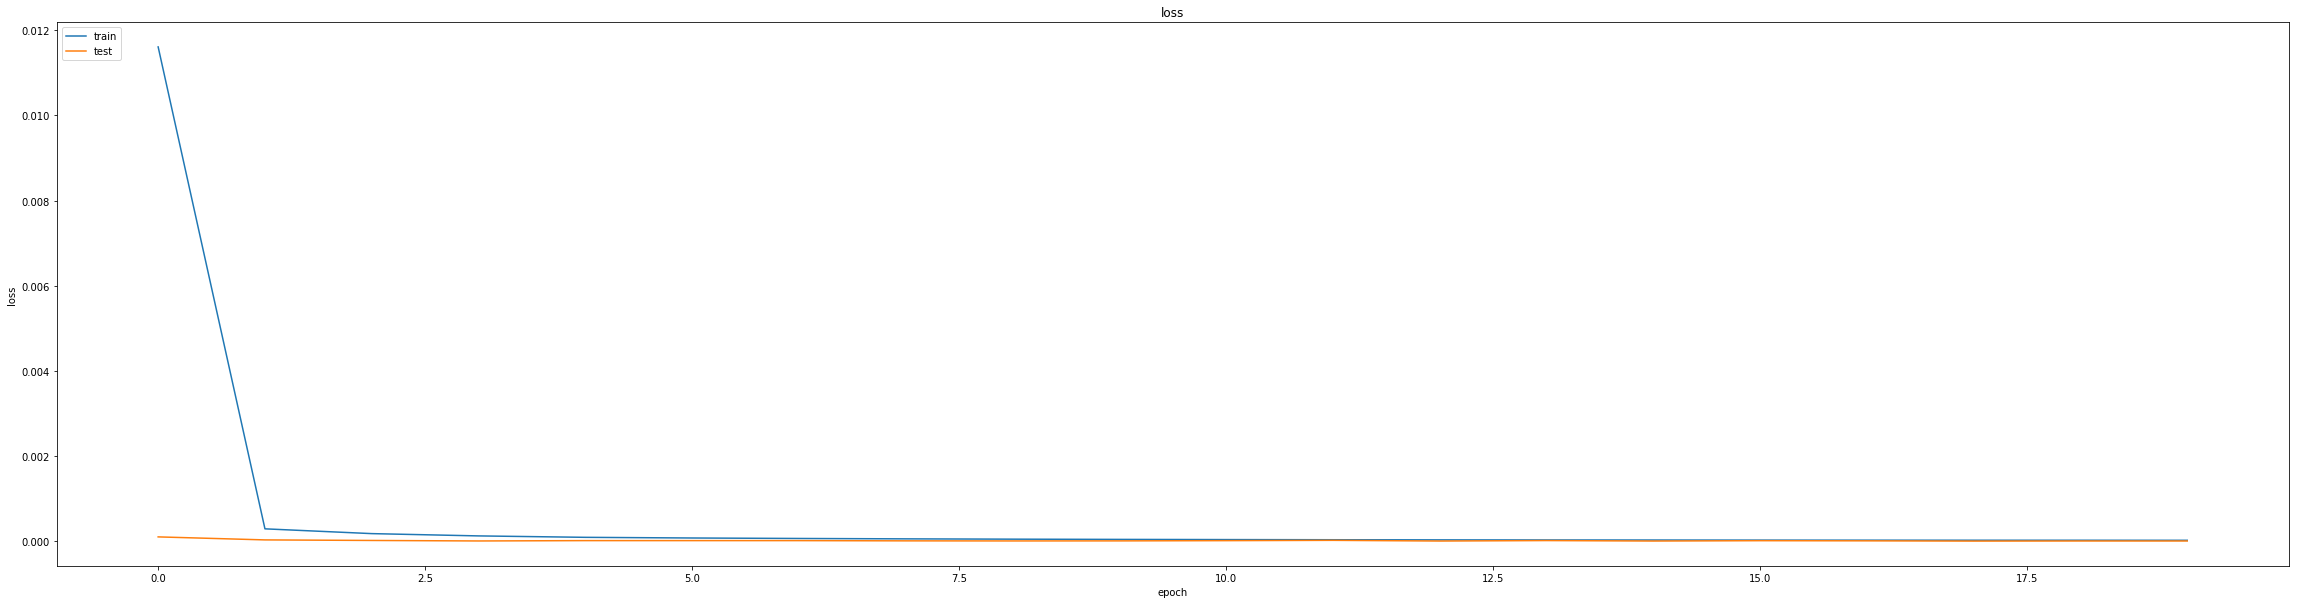

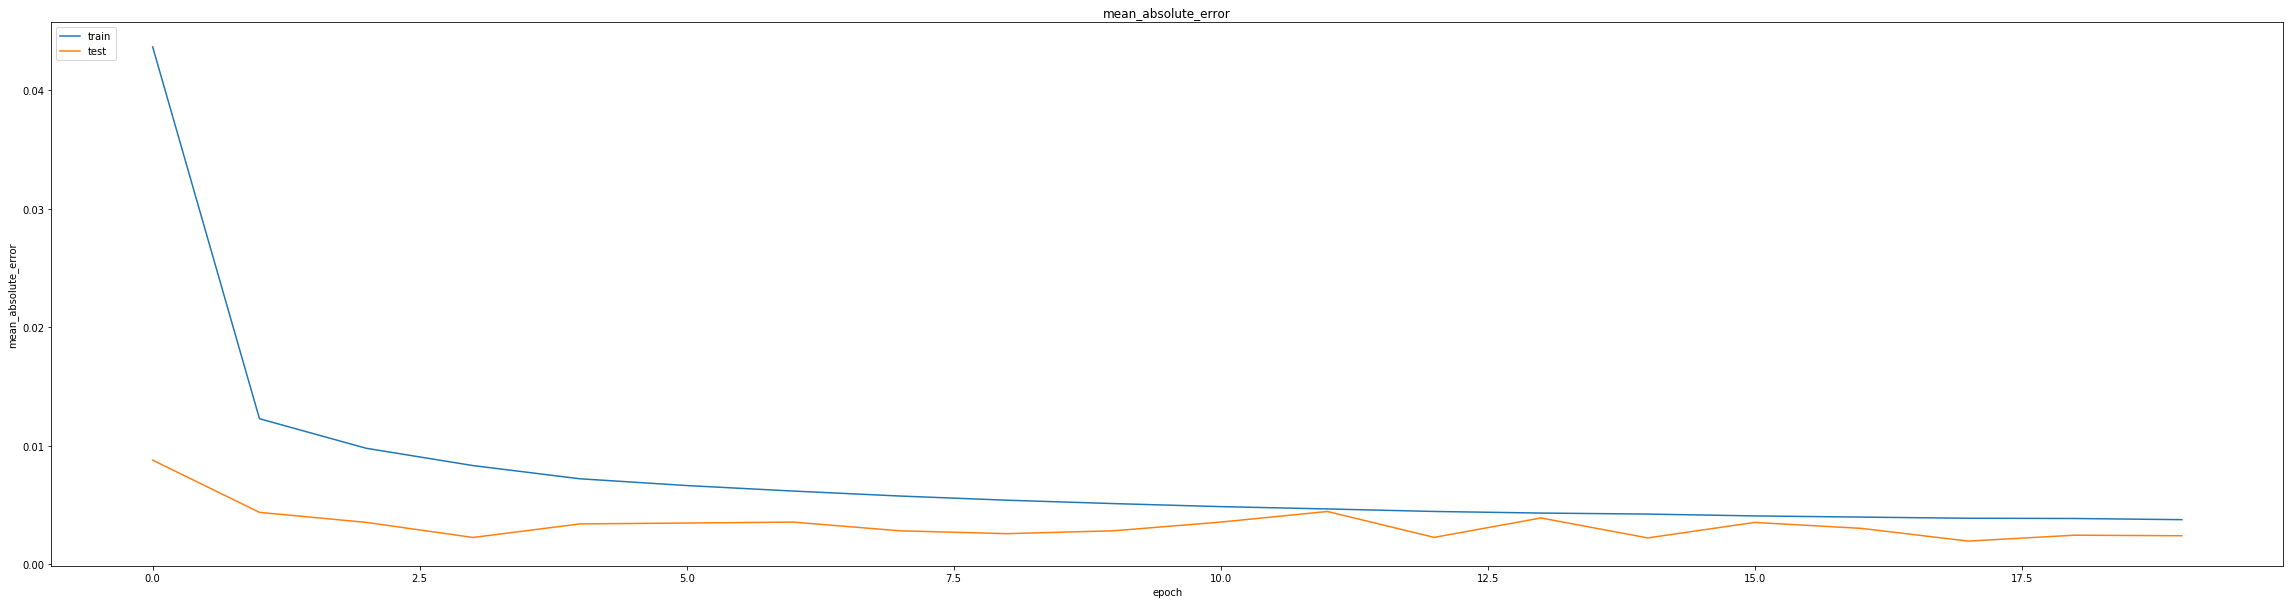

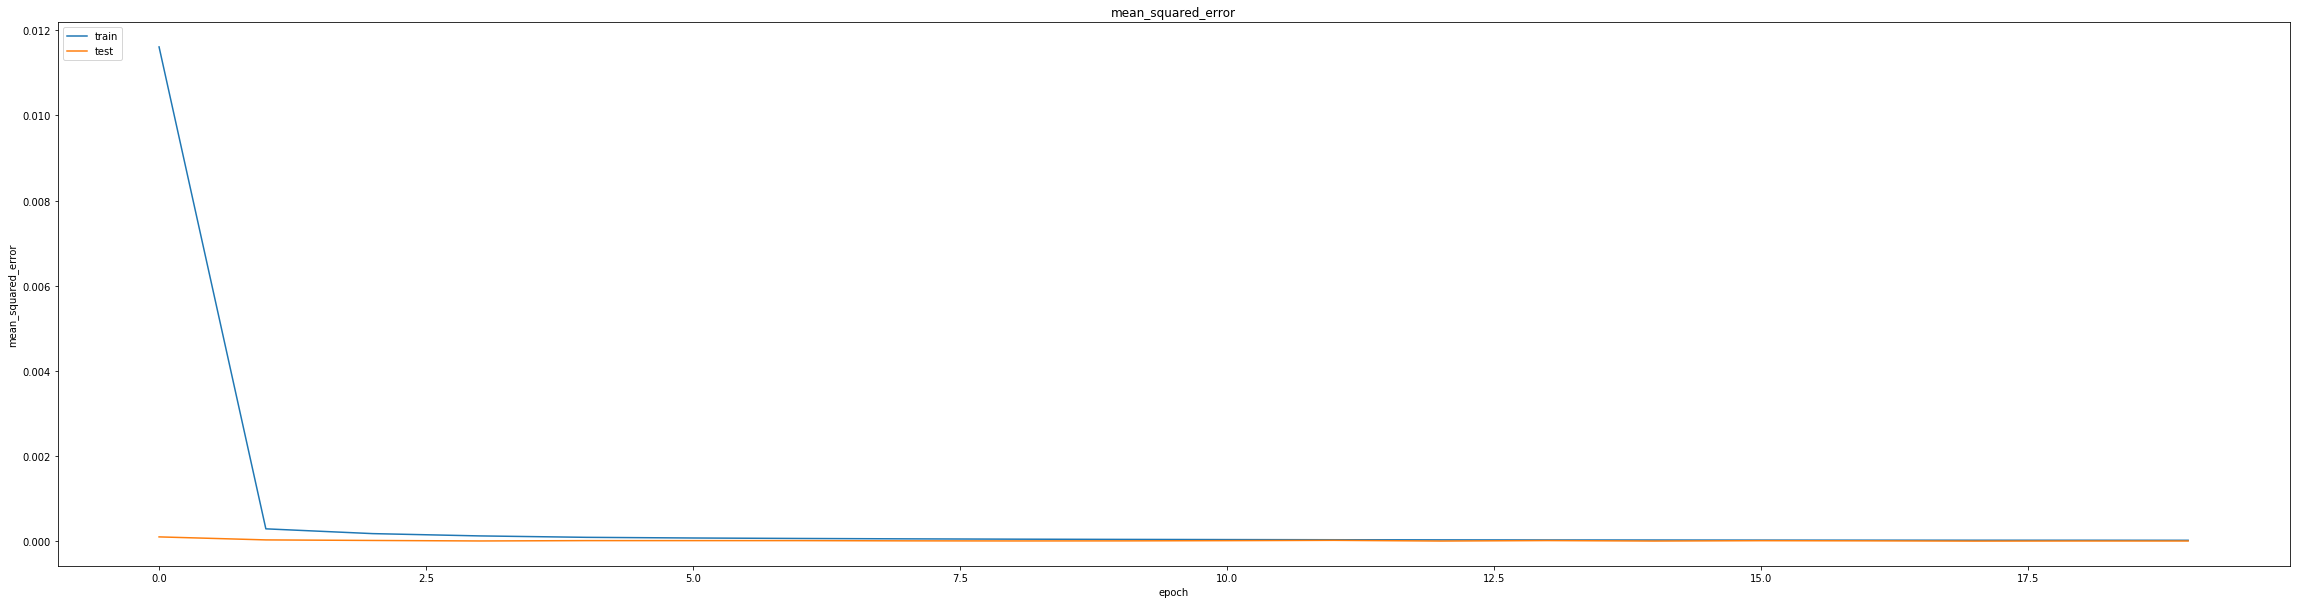

In [0]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [0]:
min(history.history['val_mean_absolute_error'])


0.0019596569734234228

In [0]:
#distance pred vs actual

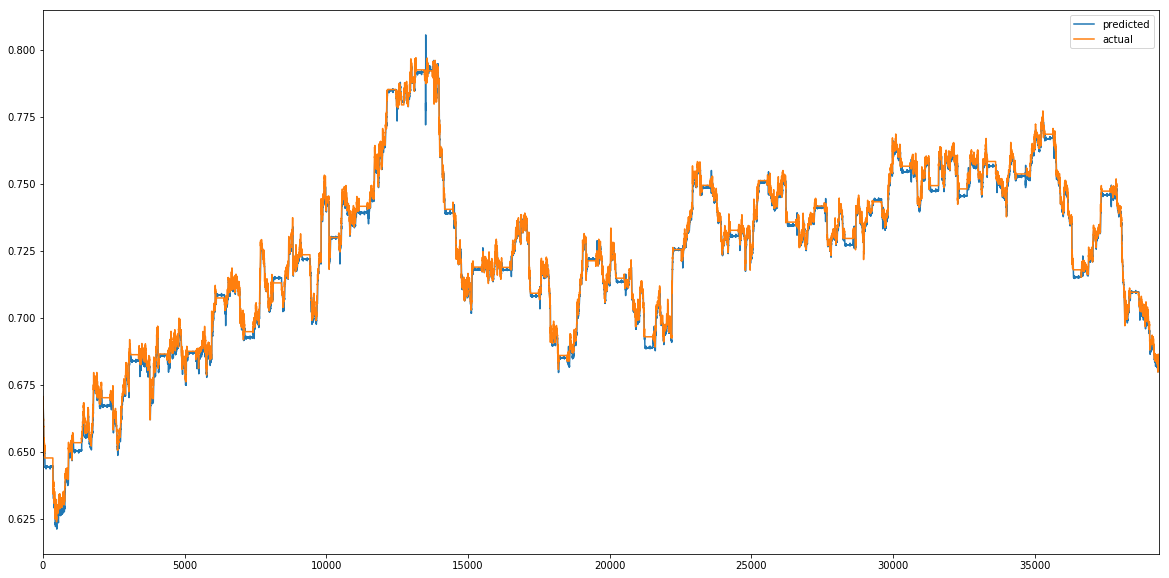

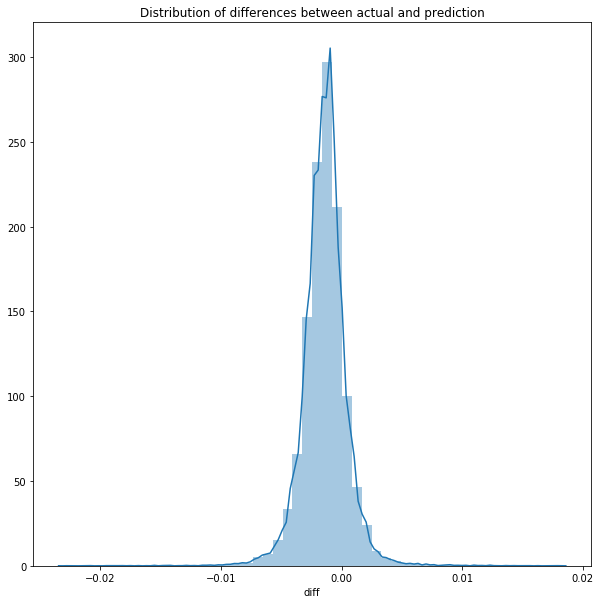

MSE :  5.337242487858588e-06
MAE :  0.0017887533719122238


count    39378.000000
mean        -0.001395
std          0.001841
min         -0.022948
25%         -0.002336
50%         -0.001359
75%         -0.000472
max          0.018080
Name: diff, dtype: float64

In [0]:
pred = model_SRNN.predict(testX)

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = testY
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

#Second Model - GRU with SELU activation function 

In [0]:
# create a GRU network
model_GRU = Sequential()
model_GRU.add(GRU(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_GRU.add(GRU(20, return_sequences=True))
model_GRU.add(GRU(10, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(4, return_sequences=False))
model_GRU.add(Dense(4, kernel_initializer='uniform', activation='selu'))
model_GRU.add(Dense(1, kernel_initializer='uniform', activation='selu'))

model_GRU.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model_GRU.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 12, 20)            2040      
_________________________________________________________________
gru_2 (GRU)                  (None, 12, 20)            2460      
_________________________________________________________________
gru_3 (GRU)                  (None, 12, 10)            930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 10)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 4)                 180       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total para

In [0]:
# Save the best weight during training.
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best.weights", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint]
history = model_GRU.fit(trainX, trainY, epochs=20, batch_size=250, verbose=0, callbacks=callbacks_list, validation_split=0.1)


Epoch 00001: val_mean_squared_error improved from inf to 0.00002, saving model to best.weights

Epoch 00002: val_mean_squared_error did not improve from 0.00002

Epoch 00003: val_mean_squared_error improved from 0.00002 to 0.00001, saving model to best.weights

Epoch 00004: val_mean_squared_error did not improve from 0.00001

Epoch 00005: val_mean_squared_error improved from 0.00001 to 0.00001, saving model to best.weights

Epoch 00006: val_mean_squared_error did not improve from 0.00001

Epoch 00007: val_mean_squared_error did not improve from 0.00001

Epoch 00008: val_mean_squared_error did not improve from 0.00001

Epoch 00009: val_mean_squared_error did not improve from 0.00001

Epoch 00010: val_mean_squared_error did not improve from 0.00001

Epoch 00011: val_mean_squared_error did not improve from 0.00001

Epoch 00012: val_mean_squared_error did not improve from 0.00001

Epoch 00013: val_mean_squared_error did not improve from 0.00001

Epoch 00014: val_mean_squared_error did not

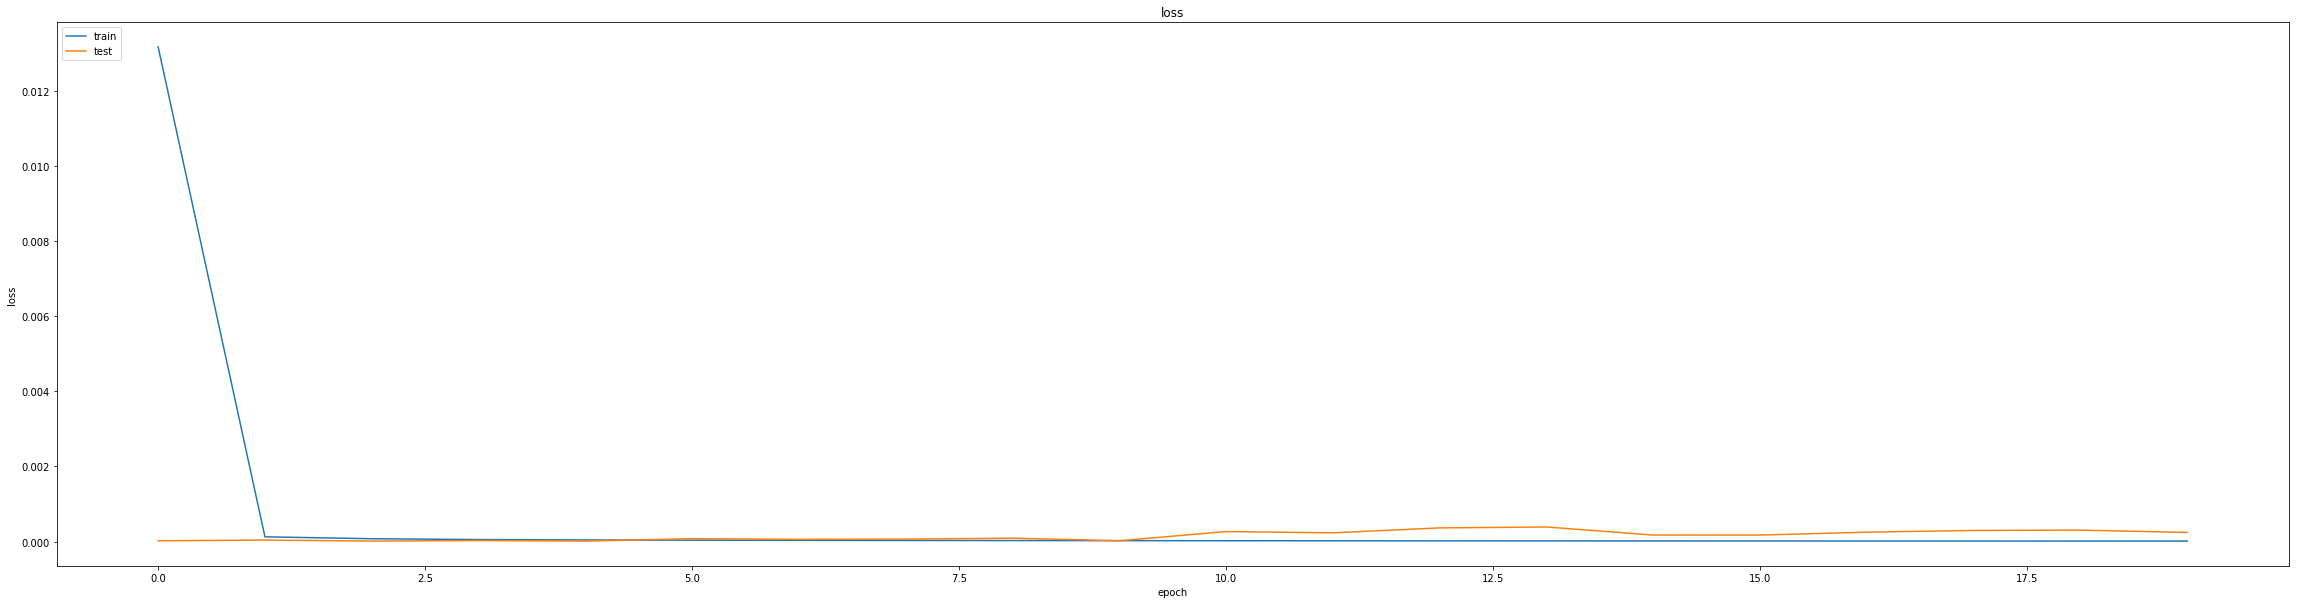

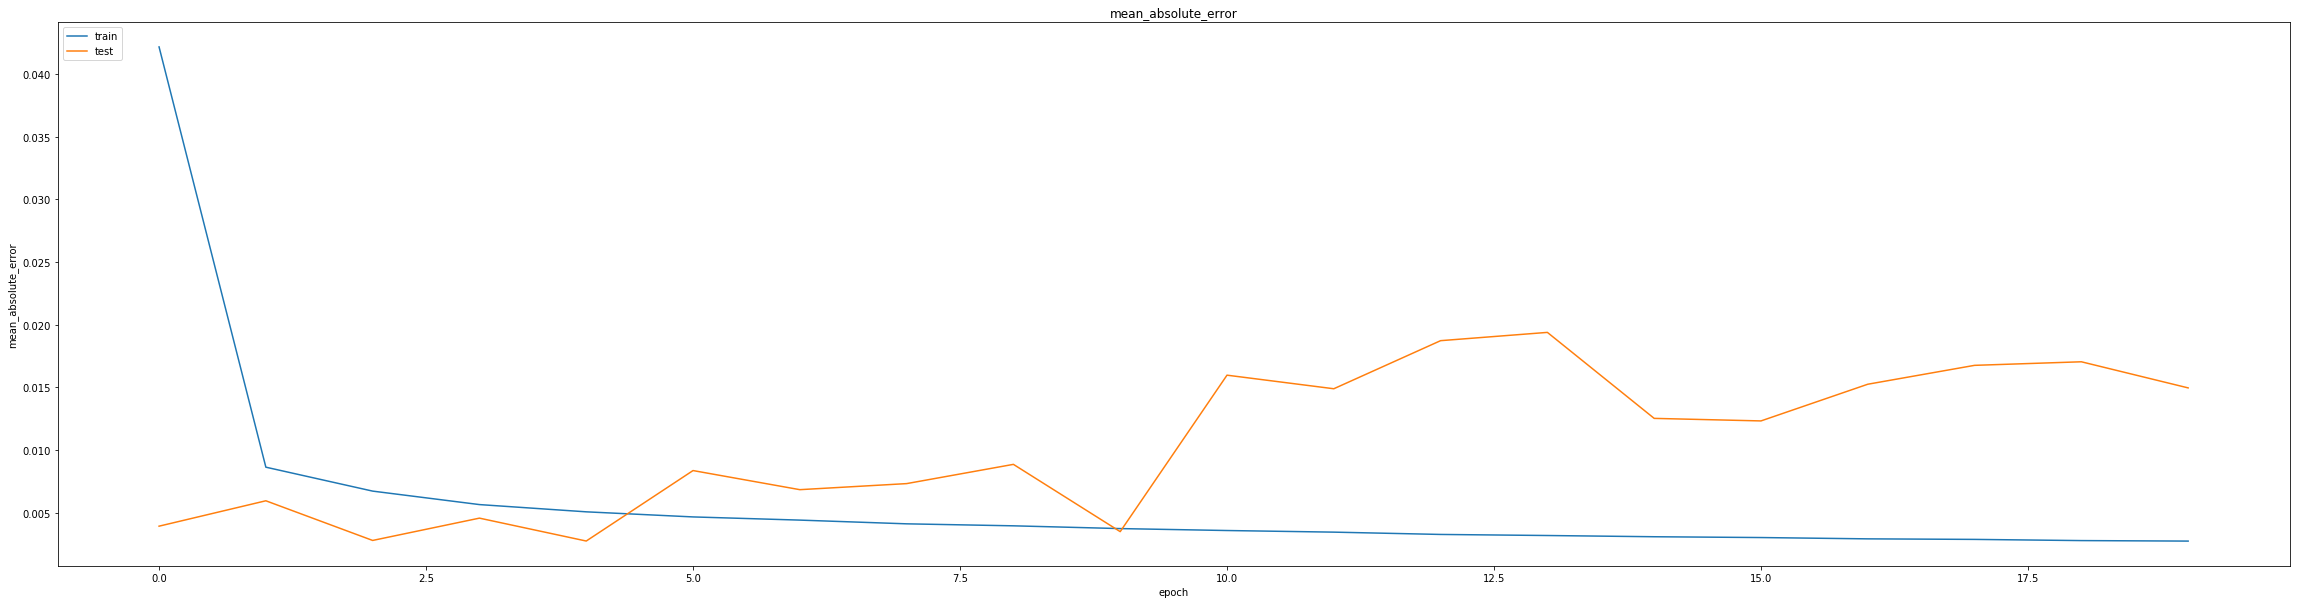

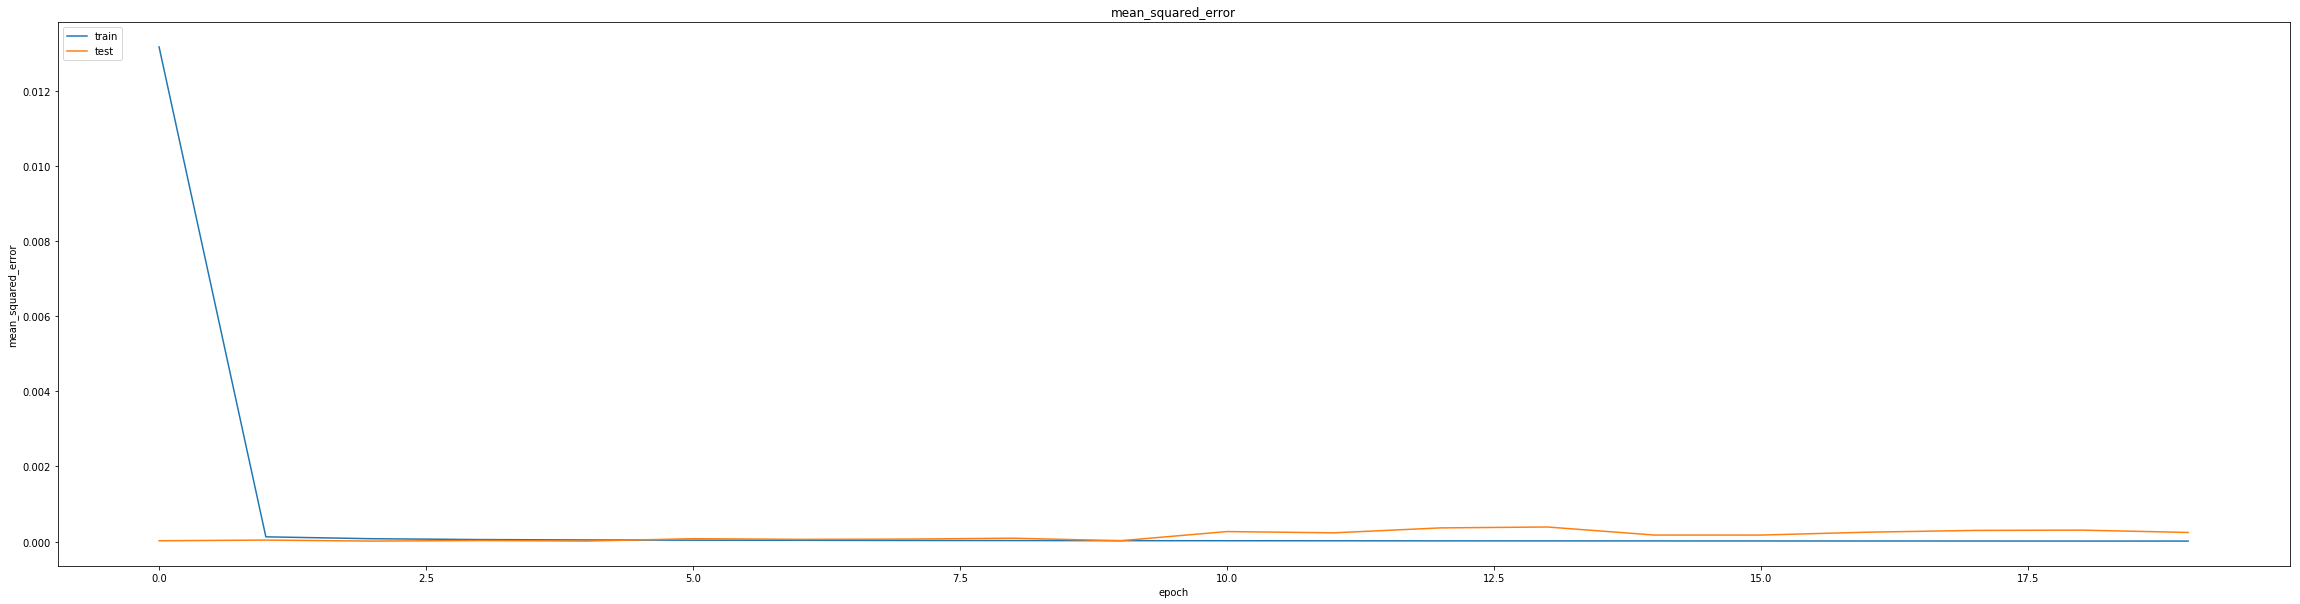

In [0]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [0]:
min(history.history['val_mean_absolute_error'])


0.002727202182855192

In [0]:
#distance pred vs actual

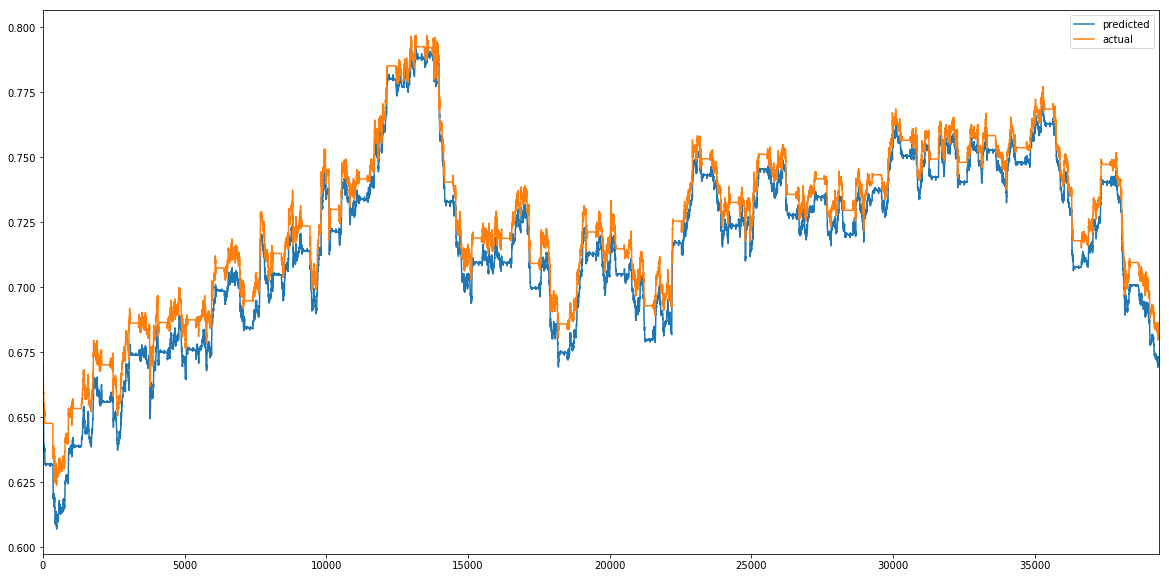

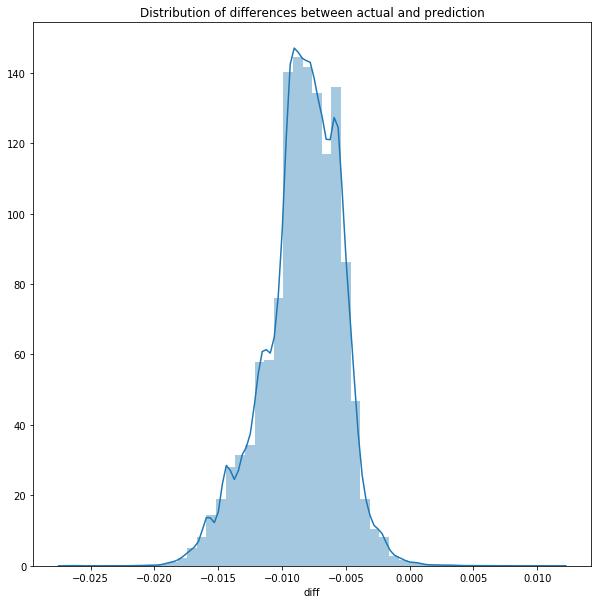

MSE :  7.897486905693761e-05
MAE :  0.008390146243553465


count    39378.000000
mean        -0.008384
std          0.002946
min         -0.026465
25%         -0.009937
50%         -0.008145
75%         -0.006255
max          0.011197
Name: diff, dtype: float64

In [0]:
pred = model_GRU.predict(testX)

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = testY
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

#Third Model - LSTM with SELU activation function

In [0]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_LSTM.add(LSTM(20, return_sequences=True))
model_LSTM.add(LSTM(10, return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(4, return_sequences=False))
model_LSTM.add(Dense(4, kernel_initializer='uniform', activation='selu'))
model_LSTM.add(Dense(1, kernel_initializer='uniform', activation='selu'))

model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model_LSTM.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 20)            2720      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 10)            1240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 10)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total para

In [0]:
# Save the best weight during training.

checkpoint = ModelCheckpoint("best.weights", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint]
history = model_LSTM.fit(trainX, trainY, epochs=20, batch_size=250, verbose=0, callbacks=callbacks_list, validation_split=0.1)


Epoch 00001: val_mean_squared_error improved from inf to 0.00002, saving model to best.weights

Epoch 00002: val_mean_squared_error improved from 0.00002 to 0.00001, saving model to best.weights

Epoch 00003: val_mean_squared_error did not improve from 0.00001

Epoch 00004: val_mean_squared_error did not improve from 0.00001

Epoch 00005: val_mean_squared_error did not improve from 0.00001

Epoch 00006: val_mean_squared_error did not improve from 0.00001

Epoch 00007: val_mean_squared_error did not improve from 0.00001

Epoch 00008: val_mean_squared_error did not improve from 0.00001

Epoch 00009: val_mean_squared_error did not improve from 0.00001

Epoch 00010: val_mean_squared_error improved from 0.00001 to 0.00001, saving model to best.weights

Epoch 00011: val_mean_squared_error improved from 0.00001 to 0.00001, saving model to best.weights

Epoch 00012: val_mean_squared_error did not improve from 0.00001

Epoch 00013: val_mean_squared_error improved from 0.00001 to 0.00000, savin

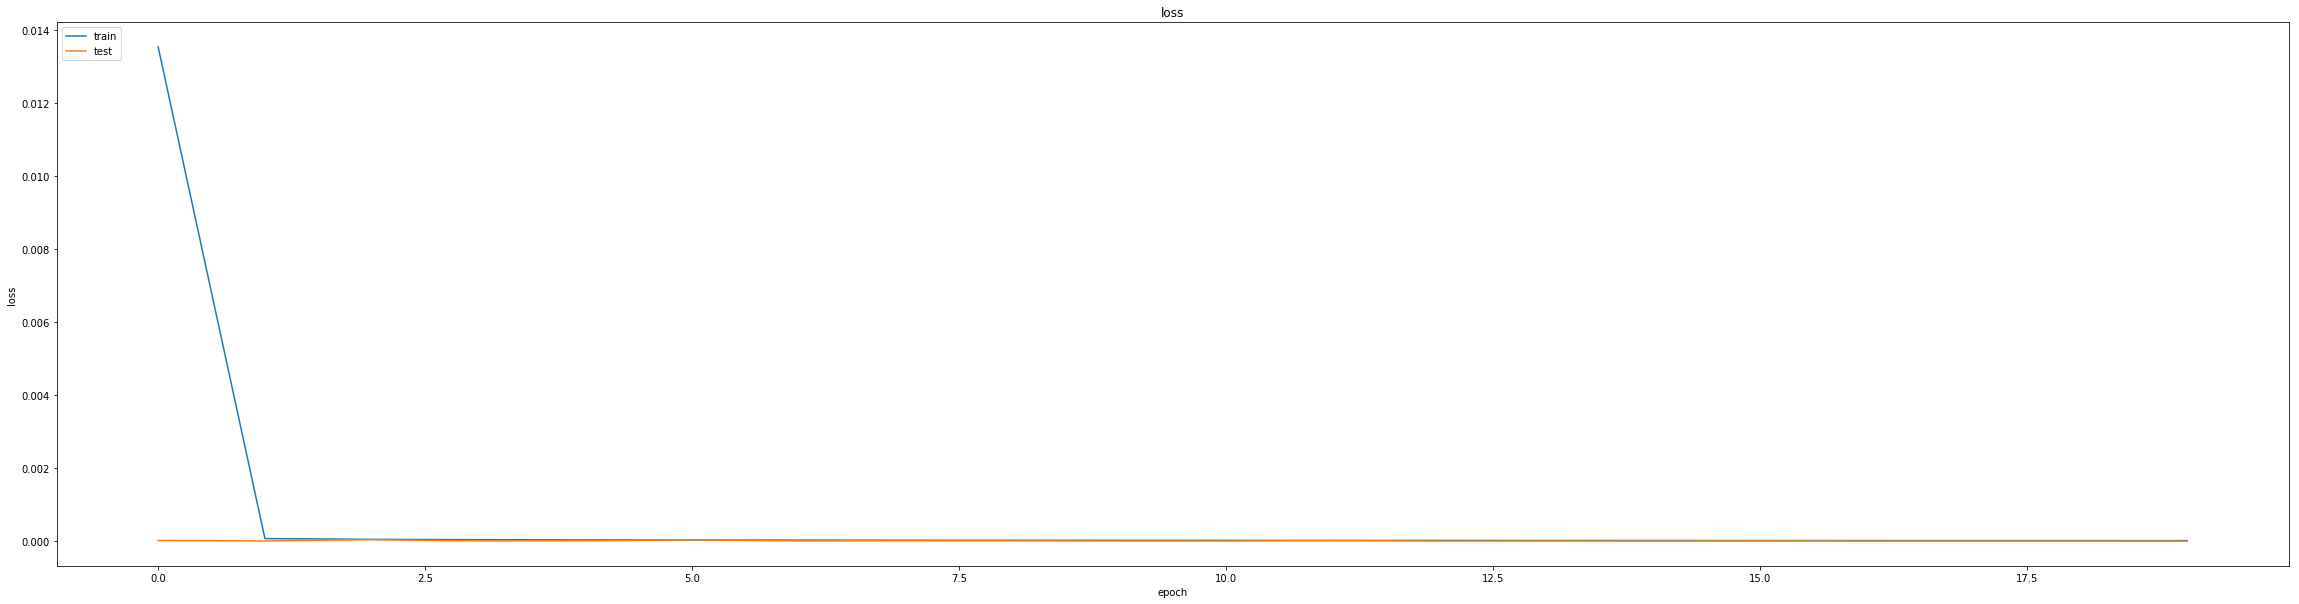

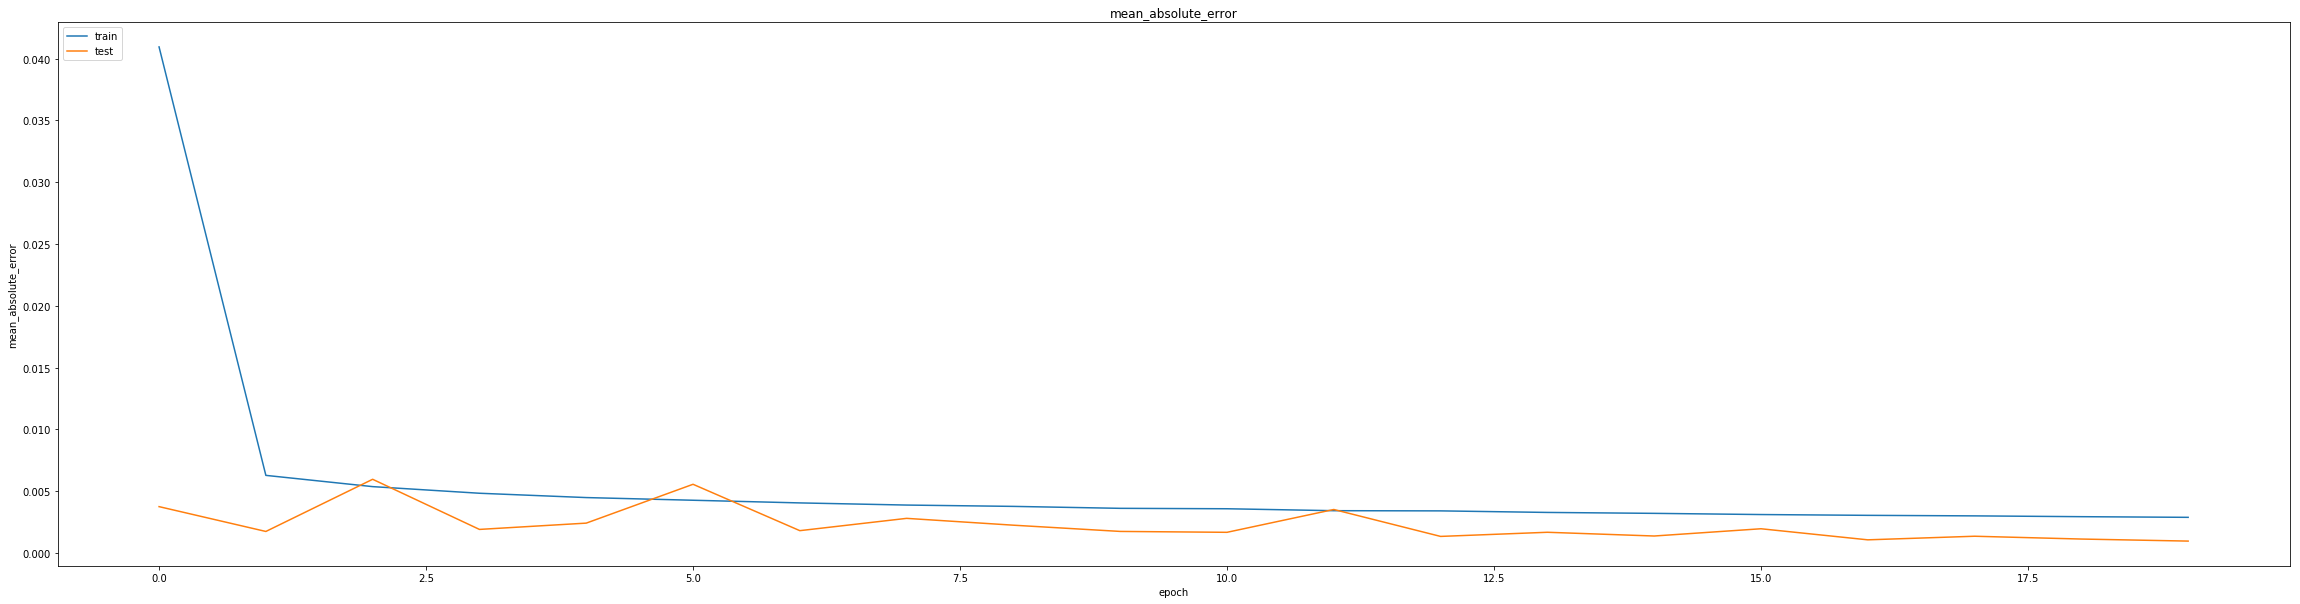

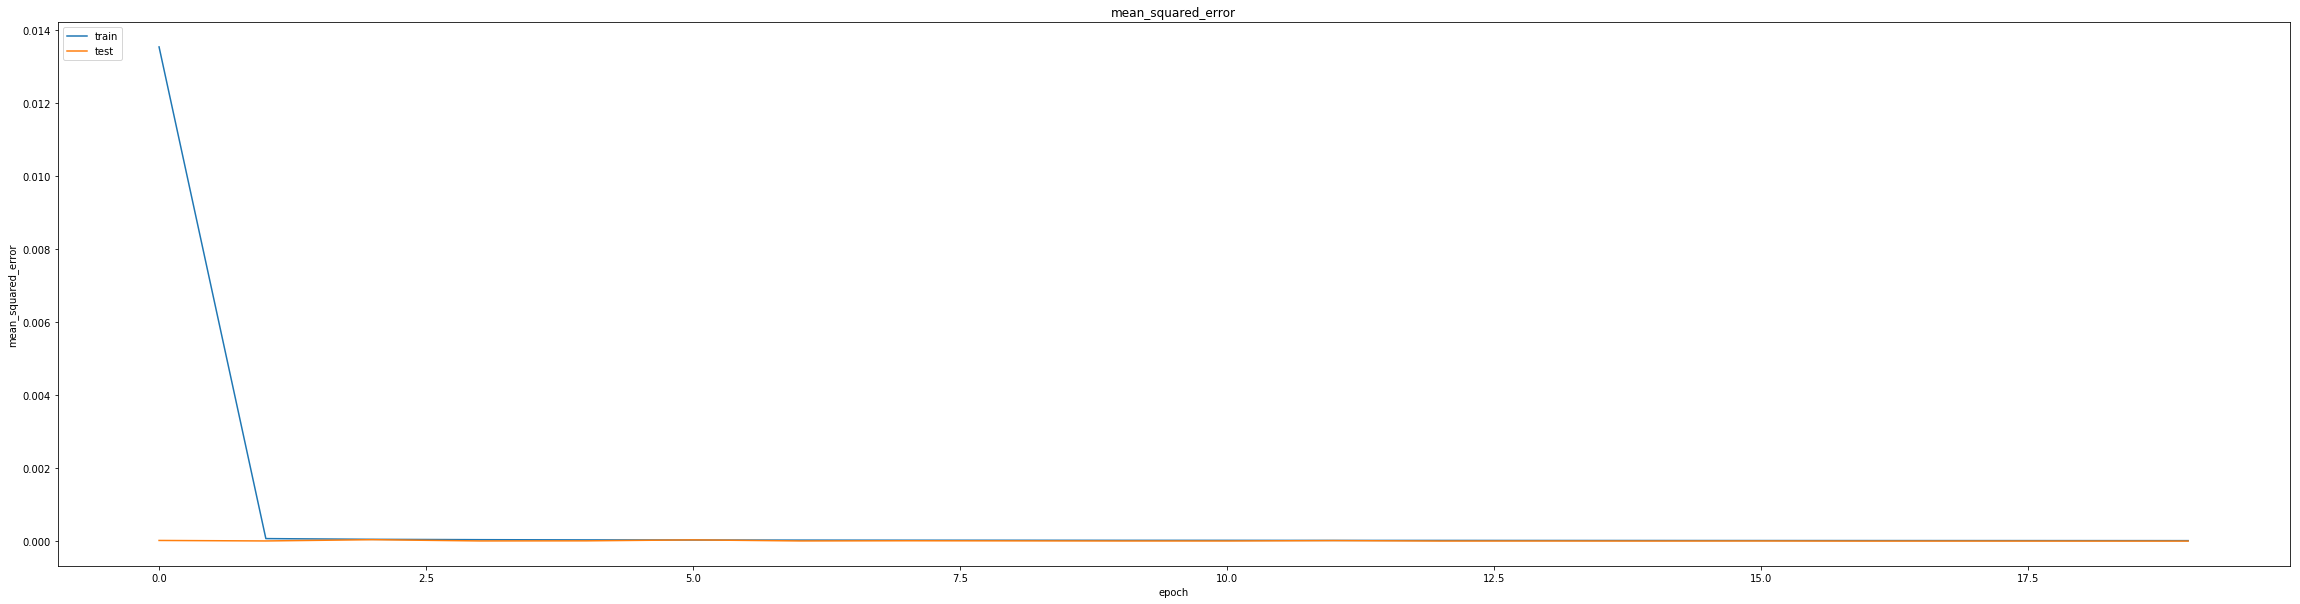

In [0]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [0]:
min(history.history['val_mean_absolute_error'])



0.0009580166835113719

In [0]:
#distance pred vs actual

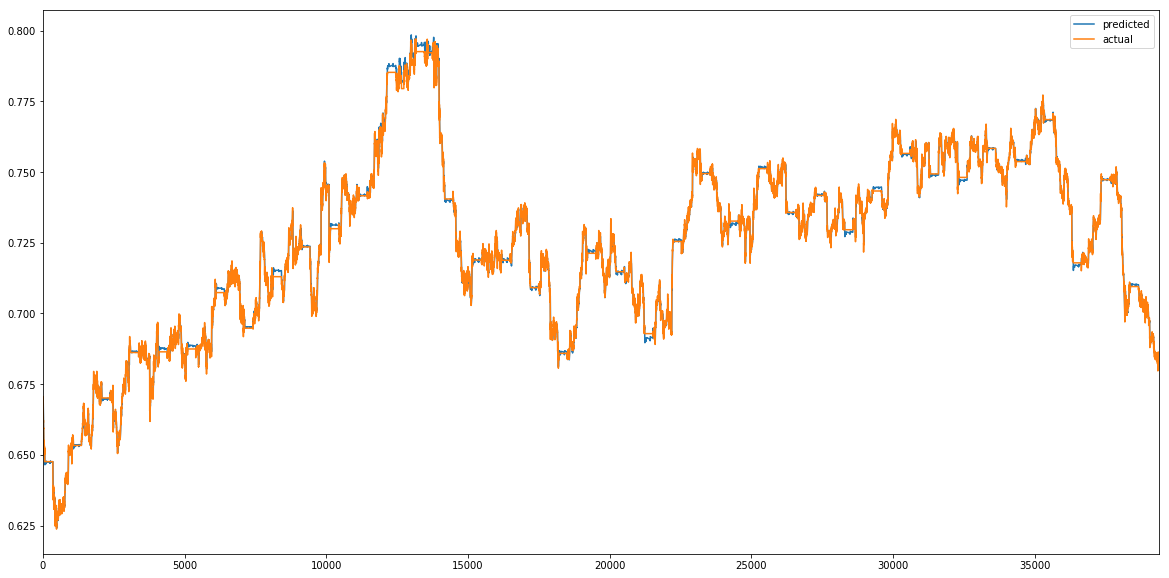

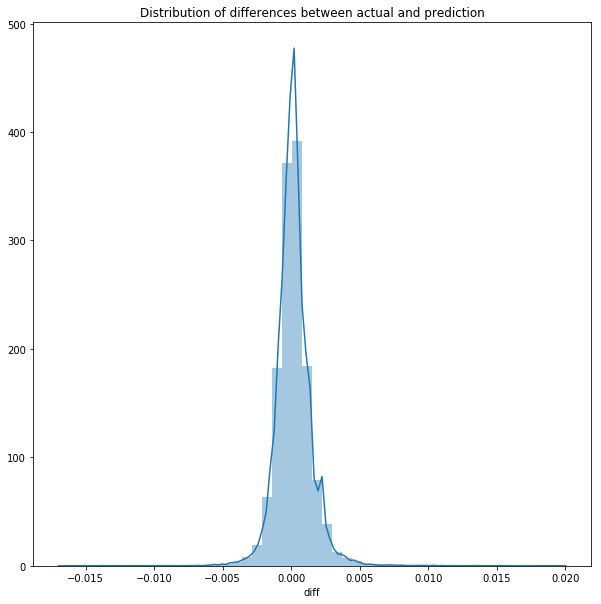

MSE :  1.7412742283688486e-06
MAE :  0.0008963010419988664


count    39378.000000
mean         0.000188
std          0.001306
min         -0.016626
25%         -0.000489
50%          0.000130
75%          0.000769
max          0.019689
Name: diff, dtype: float64

In [0]:
pred = model_LSTM.predict(testX)

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = testY
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

#Enhanced Third Model - LSTM with reduced learning rate

In [0]:
# Train again with decaying learning rate

model_LSTM.load_weights("best.weights")

from keras.callbacks import LearningRateScheduler
import keras.backend as K

def schedular(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model_LSTM.optimizer.lr)
        K.set_value(model_LSTM.optimizer.lr, lr*.85)
        print("lr changed to {}".format(lr*.85))
    return K.get_value(model_LSTM.optimizer.lr)
lr_decay = LearningRateScheduler(schedular)

callbacks_list = [checkpoint, lr_decay]
history = model_LSTM.fit(trainX, trainY, epochs=int(epoch/3), batch_size=250, verbose=0, callbacks=callbacks_list, validation_split=0.1)


Epoch 00001: val_mean_squared_error did not improve from 0.00000

Epoch 00002: val_mean_squared_error did not improve from 0.00000
lr changed to 0.0008500000403728336

Epoch 00003: val_mean_squared_error did not improve from 0.00000

Epoch 00004: val_mean_squared_error improved from 0.00000 to 0.00000, saving model to best.weights
lr changed to 0.0007225000590551645

Epoch 00005: val_mean_squared_error did not improve from 0.00000

Epoch 00006: val_mean_squared_error did not improve from 0.00000


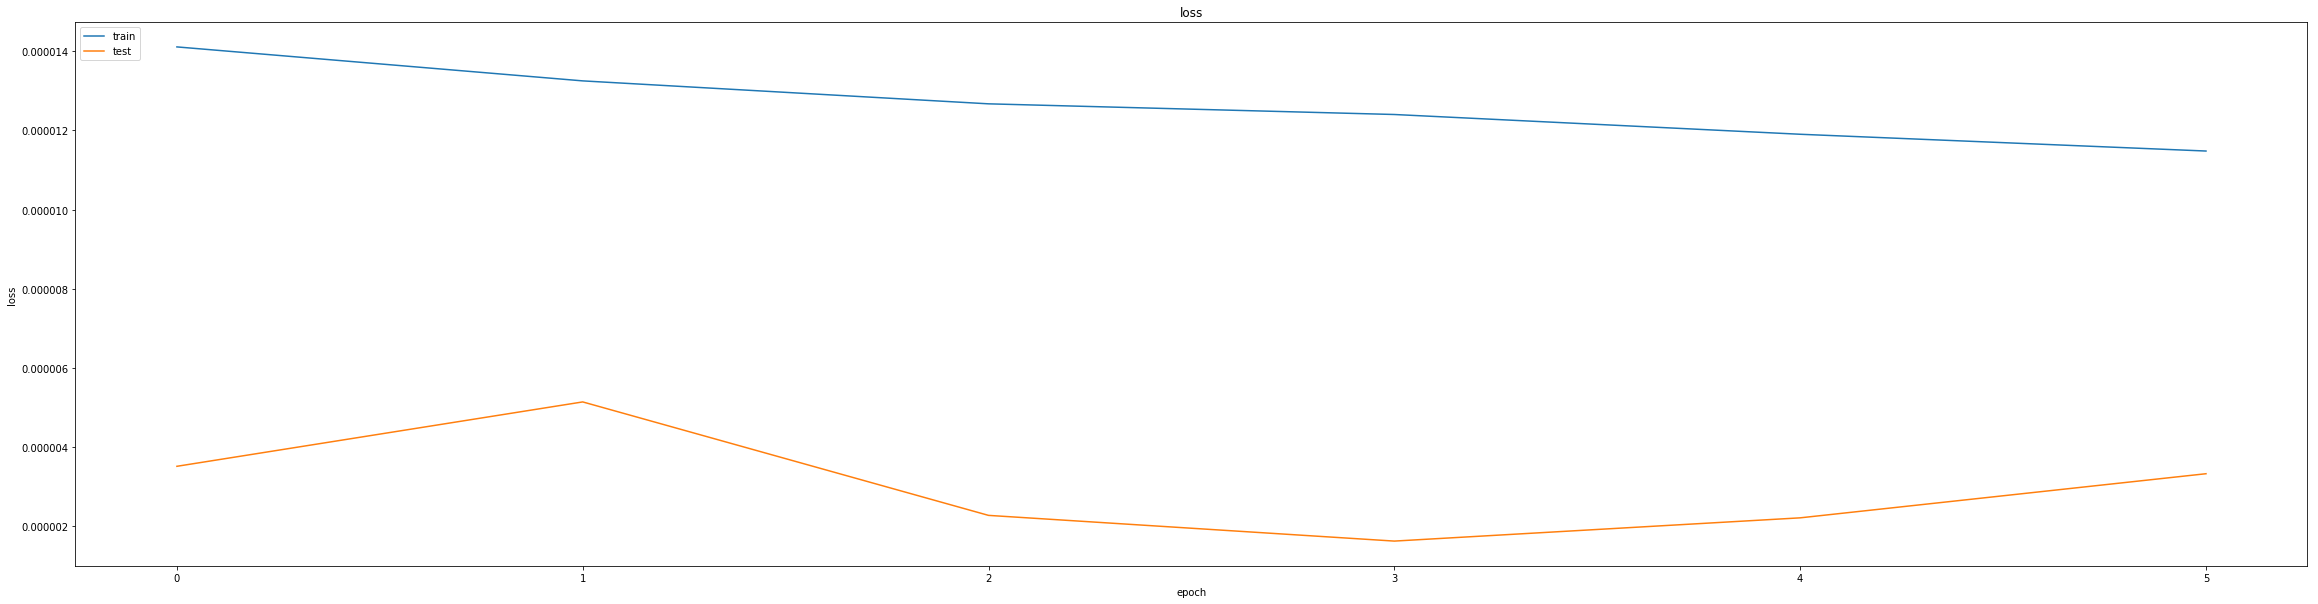

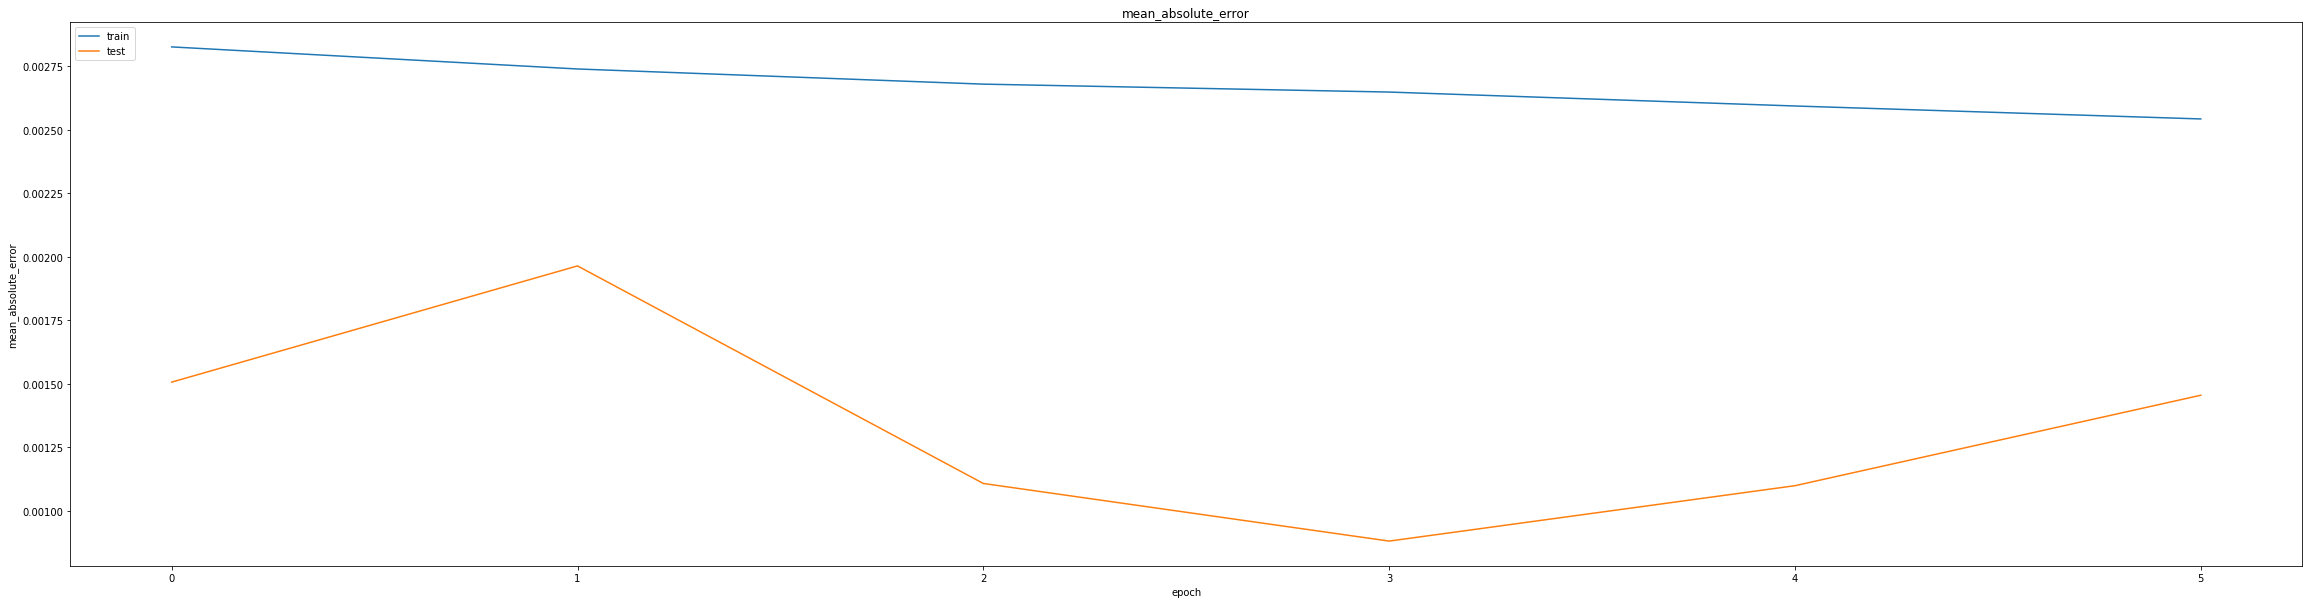

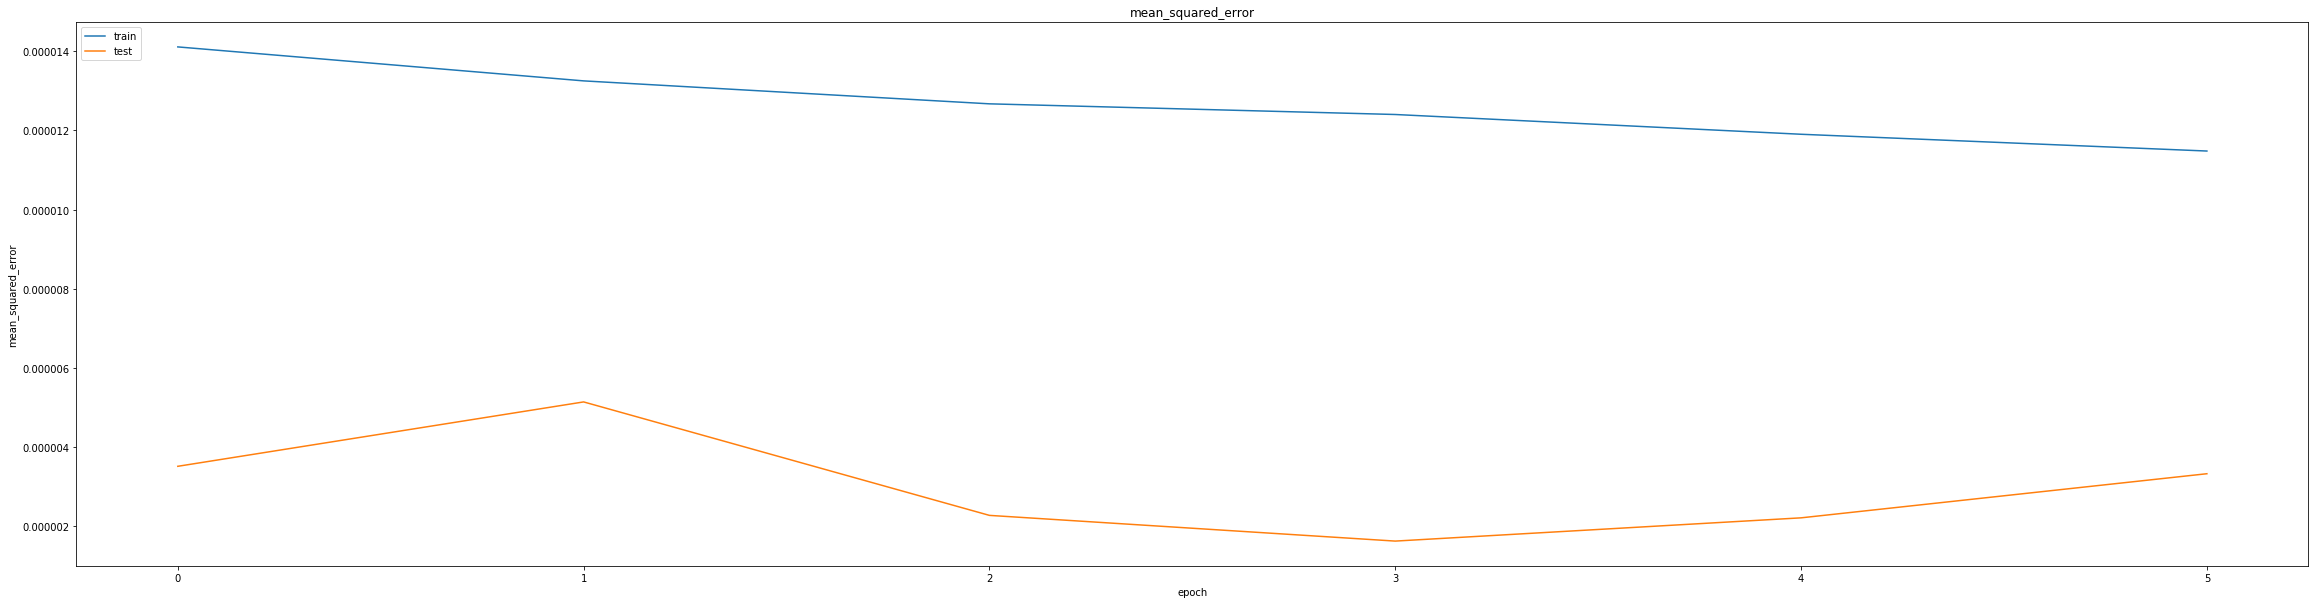

In [0]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k and 'lr' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()


In [0]:
min(history.history['val_mean_absolute_error'])


0.0008809745570288132

In [0]:
#distance pred vs actual

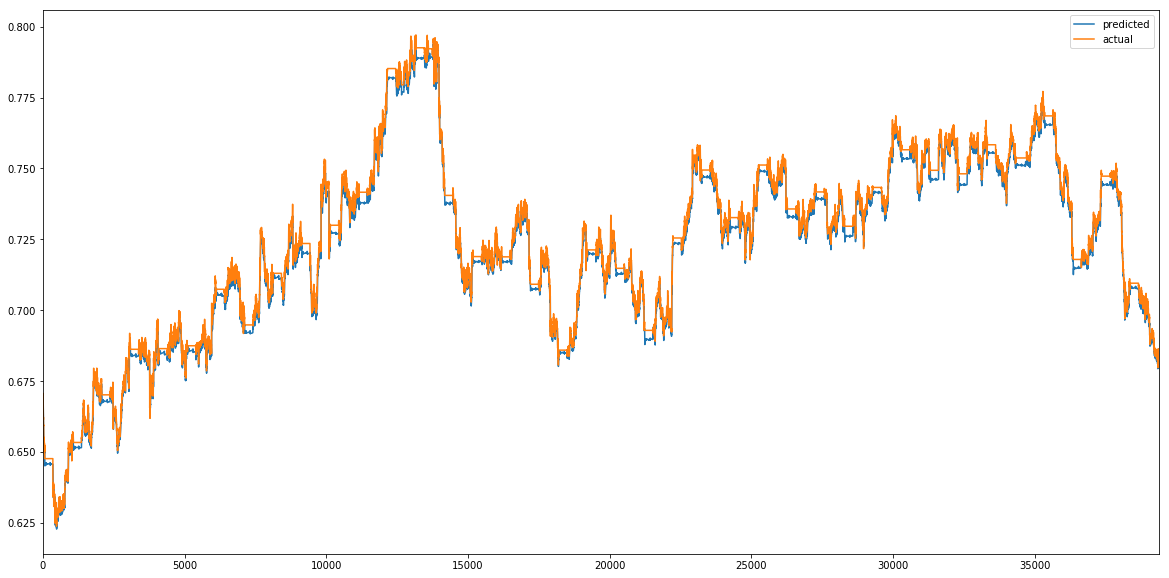

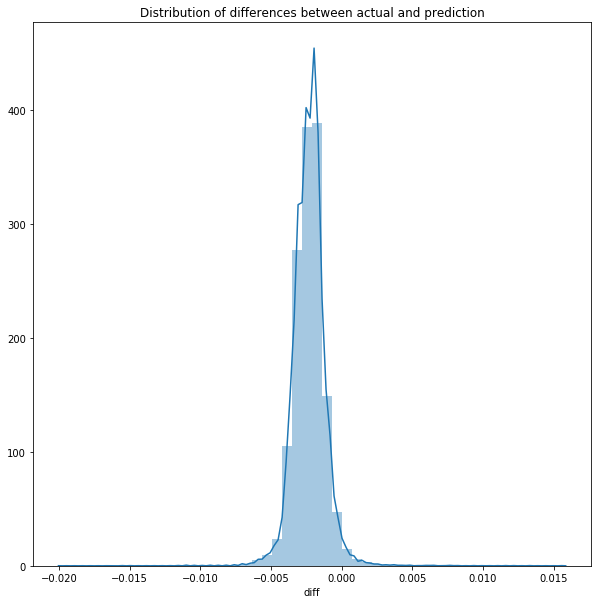

MSE :  6.479176166595854e-06
MAE :  0.0023310525550287197


count    39378.000000
mean        -0.002280
std          0.001133
min         -0.019684
25%         -0.002949
50%         -0.002265
75%         -0.001695
max          0.015507
Name: diff, dtype: float64

In [0]:
pred = model_LSTM.predict(testX)

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = testY
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

#Summary
##1) first we tried to use the mins data but the entire dataset has 3.5million data point where we dont have enough calculation power on colab to excute
##2) then we looked at the daily data for the last 7 years. The data set is not large enough for the model to learn
##3) eventually to balance out the traning capability and data size, we decided to use the 10min interval data for last 7 years
##4) the LSTM model yields the best result from the model we have tested.
##5) In theory, GRU is supposed to give similiar result as LSTM but might require some hyperparameter tuning
##6) Simple RNN preformed reletively well 
##7) if we had more time, we can try to explore the following to improve the model
###a) add feature to indicate if the fx market is open/close
###b) add volume as part of the dataset to calculate momentum impact as a new feature
###c) add sentiment analysis by incoporating some NLP techniques
